# 集成学习和随机森林

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

## 投票分类

硬投票分类器：整合每一个分类器的预测然后经过投票去预测分类  
软投票分类器：以最高的类概率来预测这个类

使用的算法要尽量不同，这样会使他们不会做出同样的错误，从而提高集成学习的正确率

### 有偏差硬币实验

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

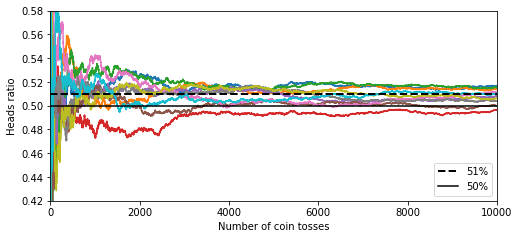

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

实验原理---大数定理

同样的，假设你创建了一个包含 1000 个分类器的集成模型，其中每个分类器的正确率只有51%（仅比瞎猜好一点点） 。如果你用投票去预测类别，你可能得到 75% 的准确率

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500,noise=0.30,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

### 硬投票

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear',random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10,random_state=42)
svm_clf = SVC(gamma='auto',random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)

In [6]:
voting_clf.fit(X,y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### 软投票

In [8]:
log_clf = LogisticRegression(solver='liblinear',random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10,random_state=42)
svm_clf = SVC(gamma='auto',probability=True,random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [9]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Bagging 和 Pasting

对每一个分类器都使用相同的训练算法，但是在不同的训练集上去训练它们（投票使用的是不同的算法，同样的训练数据）

有放回采样被称为装袋（Bagging，是 bootstrap aggregating 的缩写） 。无放回采样称为粘贴（pasting）

学习算法要求“好而不同”

### Bagging

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,max_samples=100,
                            bootstrap=True,n_jobs=-1,random_state=42)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

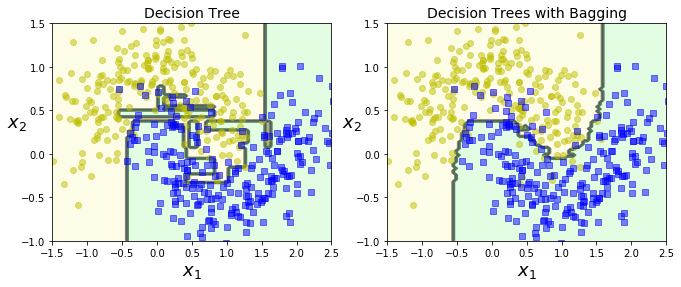

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

对比了单一决策树的决策边界和 Bagging 集成 500 个树的决策边界，两者都在 moons数据集上训练。正如你所看到的，集成的分类比起单一决策树的分类产生情况更好：集成有一个还行的偏差但是有一个较小的方差（它在训练集上的错误数目大致相同，但决策边界较不规则） 。

### Pasting

In [15]:
# bootstrap=False 就是Pasting
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,max_samples=100,
                            bootstrap=False,n_jobs=-1,random_state=42)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
print(accuracy_score(y_test, y_pred))

0.912


Bootstrap 在每个预测器被训练的子集中引入了更多的分集，所以 Bagging 结束时的偏差比Pasting 更高，但这也意味着预测因子最终变得不相关，从而减少了集合的方差。   
总体而言，Bagging 通常会导致更好的模型，这就解释了为什么它通常是首选的。

### Out-of-Bag 评价

对于 Bagging 来说，一些实例可能被一些分类器重复采样，但其他的有可能不会被采样。这意味着平均下来只有63%的训练实例被每个分类器采样，剩下的37%个没有被采样的训练实例就叫做 Out-of-Bag 实例

注意对于每一个的分类器它们的 37% 不是相同的。

因为在训练中分类器从来没有看到过 oob 实例，所以它可以在这些实例上进行评估，而不需要单独的验证集或交叉验证。你可以拿出每一个分类器的 oob 来评估集成本身。

In [17]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,max_samples=100,
                            bootstrap=True,n_jobs=-1,oob_score=True,random_state=42)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
bag_clf.oob_score_

0.9253333333333333

In [18]:
accuracy_score(y_test,y_pred)

0.904

## 随机森林

随机森林是决策树的一种集成，通常是通过 bagging 方法（有时是pasting 方法） 进行训练

In [19]:
#500个树，16个叶节点
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1,random_state=42)
rnd_clf.fit(X_train,y_train)

y_pred_rnd = rnd_clf.predict(X_test)

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random',max_leaf_nodes=16,random_state=42),
    n_estimators=500,max_samples=1.0,bootstrap=True,n_jobs=-1,random_state=42
)

In [21]:
bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)

In [22]:
accuracy_score(y_pred_bag,y_pred_rnd)

0.976

从预测的数据相似度，印证了随机森林就是决策树的集成

 ### 特征重要度

重要的特征会出现在更靠近根部的位置，而不重要的特征会经常出现在靠近叶子的位置  
因此我们可以通过计算一个特征在森林的全部树中出现的平均深度来预测特征的重要性

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=42)
rnd_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


最重要的特征是花瓣长度（44%） 和宽度（42%） ，而萼片长度和宽度相对比较是不重要的（分别为 11% 和2%） ：

## Boosting

提升（Boosting，最初称为假设增强） 指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类

###  Adaboost

使一个新的分类器去修正之前分类结果的方法就是对之前分类结果不对的训练实例多加关注。这导致新的预测因子越来越多地聚焦于这种情况

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm="SAMME.R",learning_rate=0.5,random_state=42
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

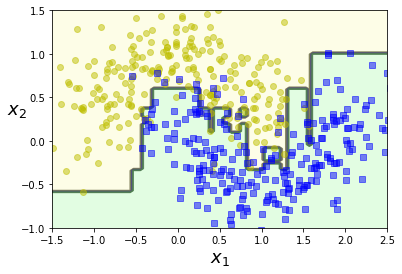

In [25]:
plot_decision_boundary(ada_clf,X,y)

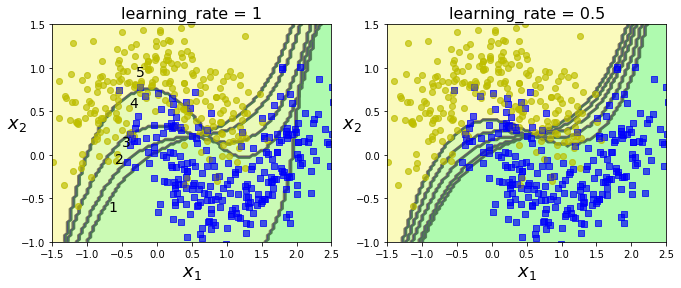

In [26]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

上面显示了连续五次预测的 moons 数据集的决策边界（在本例中，每一个分类器都是高度正则化带有 RBF 核的 SVM） 。第一个分类器误分类了很多实例，所以它们的权重被提升了。第二个分类器因此对这些误分类的实例分类效果更好，以此类推

### 梯度提升

与 Adaboost 一样，梯度提升也是通过向集成中逐步增加分类器运行的，每一个分类器都修正之前的分类结果。然而，它并不像 Adaboost 那样每一次迭代都更改实例的权重，这个方法是去使用新的分类器去拟合前面分类器预测的残差 

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [29]:
y2 = y -  tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [30]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([0.75026781])

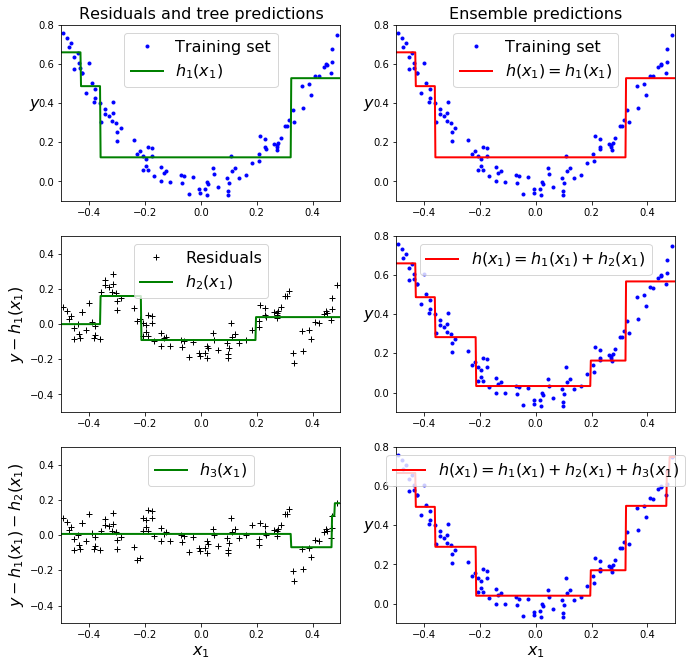

In [33]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

在第一行，集成只有一个树，所以它与第一个树的预测相似。  
在第二行，一个新的树在第一个树的残差上进行训练。在右边栏可以看出集成的预测等于前两个树预测的和。  
相同的，在第三行另一个树在第二个数的残差上训练。你可以看到集成的预测会变的更好

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=0.1,random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

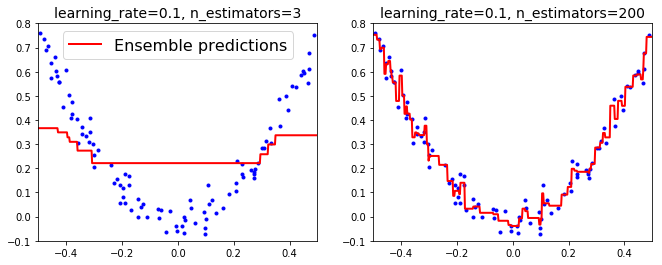

In [36]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

为了找到树的最优数量，你可以使用早停技术

### 早停技术

In [37]:
from sklearn.metrics import mean_squared_error

X_train,X_val,y_train,y_val =train_test_split(X,y,random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120,random_state=42)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators,random_state=42)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

可以看到55是最好的模型

In [38]:
min_error = np.min(errors)
min_error

0.002712853325235463

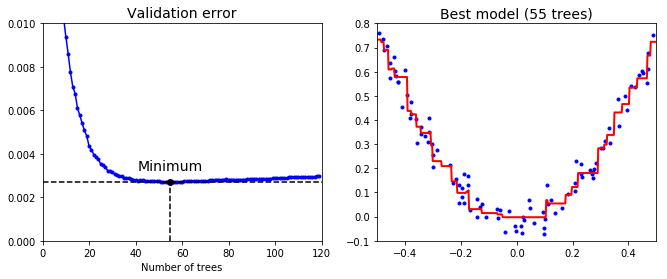

In [39]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

上面的方法是计算完后去找最小的，下面使用早停技术，五次迭代验证错误没有改善时停止训练

In [40]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators #通过赋值改变基分类器数量
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [41]:
print(gbrt.n_estimators)

61


In [42]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## Stacking

sklearn 并不直接支持 stacking ，但是可以自己组建